# Chis-Squareds of Modeled Spectra

This notebook demonstrates the chi-squared calculation for modeled spectra. Calculations are performed for each observed spectra using both the entire observed wavelength range, and also for indidividual band pass ranges.

In [1]:
import sys

import numpy as np
import sncosmo
from matplotlib import pyplot as plt
from sndata.csp import dr1, dr3

sys.path.insert(0, '../')
from analysis import models, spectra_chisq


In [2]:
# Register models and data with sncosmo
models.register_sources(force=True)
dr1.download_module_data()
dr3.download_module_data()
dr3.register_filters(force=True)

# Load models for different masses
m102 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.02))
m104 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.04))
m14 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.4))
m17 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.7))
salt2 = sncosmo.Model(sncosmo.get_source('salt2', version='2.4'))


## Defining Band Pass Limits

We define the wavelength ranges for a set of fiducial CSP band passes. We define the beginning and end of each band to occure when the transmission drops below 1%.

In [3]:
# A set of fiducial band passes.
fiducial_bands = (
    'csp_dr3_u',
    'csp_dr3_g',
    'csp_dr3_r',
    'csp_dr3_i',
    'csp_dr3_B',
    'csp_dr3_V',
    'csp_dr3_Y',
    'csp_dr3_H',
    'csp_dr3_J'
)

trans_limit = 0.01
band_ranges = dict()
for band_name in fiducial_bands:
    band = sncosmo.get_bandpass(band_name)
    transmission_limits = band.wave[band.trans >= trans_limit]
    min_wave = np.min(transmission_limits)
    max_wave = np.max(transmission_limits)
    band_ranges[band_name] = (min_wave, max_wave)
    

As a simple verification of the above cell, we plot our boundaries against the filter transmission curves.

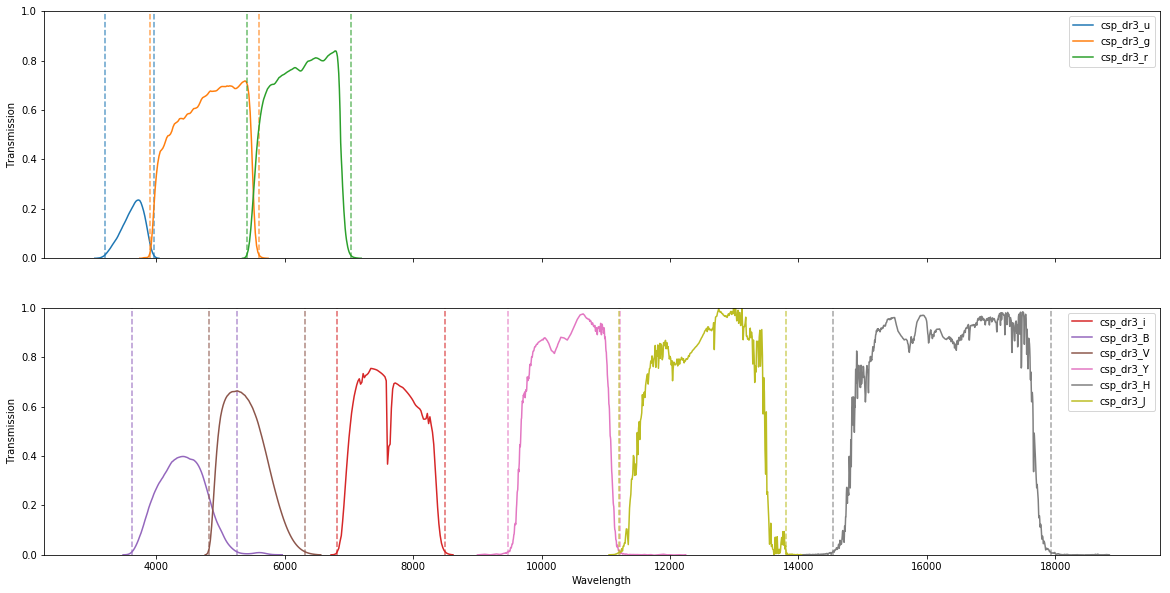

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])

for axis, bands in zip(axes.flatten(), [fiducial_bands[:3], fiducial_bands[3:]]):
    for band_name, color in zip(bands, colors):
        band = sncosmo.get_bandpass(band_name)
        axis.plot(band.wave, band.trans, label=band_name, color=color)
        min_wave, max_wave = band_ranges[band_name]
        axis.axvline(min_wave, linestyle='--', alpha=.7, color=color)
        axis.axvline(max_wave, linestyle='--', alpha=.7, color=color)
        
        axis.legend()
        axis.set_ylim(0, 1)
        axis.set_ylabel('Transmission')

axis.set_xlabel('Wavelength')
plt.show()


## Chi-squared Results

In [5]:
def get_spectra_for_id(obj_id):
    """Get spectral data for a given data id

    Args:
        obj_id (str): The ID of the desired object

    Returns:
        A list of observed MJD dates for each spectra
        A 2d list of wavelength values for each date
        A 2d list of flux values for each date
    """

    data = dr1.get_data_for_id(obj_id)
    obs_dates = list(set(data['date']))

    wavelength, flux, flux_err = [], [], []
    for date in obs_dates:
        data_for_date = data[data['date'] == date]
        wavelength.append(data_for_date['wavelength'])
        flux.append(data_for_date['flux'])
        flux_err.append(.1 * data_for_date['flux'])

    return obs_dates, wavelength, flux, flux_err


    


In [6]:
obs_dates, wavelength, flux, flux_err = get_spectra_for_id('2005kc')
modeled_flux = [m104.flux(d, w) for d, w in zip(obs_dates, wavelength)]
spectra_chisq.band_chisq_spectra(wavelength, flux, flux_err, modeled_flux, band_ranges)


{'csp_dr3_u': [1.1323321007355093e+22,
  3.004299537914051e+21,
  4.596501022593837e+21,
  1.0382877418652137e+21],
 'csp_dr3_g': [3.4403106965674703e+21,
  1.5315276712026704e+21,
  4.6006926086459286e+21,
  1.6284594785016004e+23],
 'csp_dr3_r': [6.04221608649934e+19,
  1.8510686945358135e+19,
  2.7712055199744205e+19,
  2.904078963684591e+20],
 'csp_dr3_i': [6.036517679168439e+20,
  7.087226729703256e+18,
  3.6777077872778277e+19,
  9.537128535241168e+20],
 'csp_dr3_B': [7.275007800545164e+21,
  4.1174159928880697e+21,
  5.874296896806283e+21,
  1.6077551069347067e+23],
 'csp_dr3_V': [9.999973142299118e+20,
  4.6341808782593825e+20,
  5.0974440694615815e+20,
  3.40754782416391e+22],
 'csp_dr3_Y': [0.0, 0.0, 0.0, 0.0],
 'csp_dr3_H': [0.0, 0.0, 0.0, 0.0],
 'csp_dr3_J': [0.0, 0.0, 0.0, 0.0]}